_This notebook is part of this tweet:_

Bayesians, don't use the Poisson distribution is your data isn't Poisson-distributed. It gives misleading results, because it underestimates the variance of the data and hence the variance of the posterior will be (misleadingly) small, giving your false confidence in your results.

If you have a sample of non-negative integers (maybe clicks-per-visit in an eCommerce context), it's tempting to model it as Poisson.
I'll do some simulations here to show it goes wrong if the data isn't really Poisson.

Notebook link: ...

I generate data from a Geometric distribution, as it also generates non-negative integers. But it has higher variance.

Geometric's conjugate prior is Beta, so I used p ~ Beta(α=12, β=108) and then generated sample of 1000 integers from the Geometric. Then, computed the posterior for 𝑝

$$
Generate: \qquad \qquad \qquad \qquad \qquad \qquad\\
p \sim Beta(\alpha=12, \beta=108)   \qquad \qquad  \\
\; \; \; \; x_i \sim Geometric(p)  \qquad i \in \{1,...,1000\} \\
Posterior: \qquad \qquad \qquad \qquad \qquad \qquad\\
p | \mathbf{x} \sim Beta(\alpha=12+1000, \beta=108 + \sum_{i=1}{1000})
$$

This Beta posterior is the "gold standard" - it is the posterior that comes from full knowledge of the correct data-generating process.

𝑝 is not directly of interest, so I transform it to 1/𝑝-1 as that is the mean and the mean can be compared to the Poisson's rate.

Next, to compute the Poisson, we need a Gamma model. After a bit of trial and error, I found that Gamma(α=10, β=1) is very similar (after transformation) to the Beta prior mentioned earlier. I did this deliberately so ensure Poisson was given a "fair chance". Then the corresponding Gamma prior can be updated to the Gamma posterior

$$
\lambda | \mathbf{x} \sim Gamma(\alpha=10 + \sum_{i=1}{1000}, \beta=1+1000, )
$$

I ran this many times, and varied the sample size also. In every case, the Poisson-Gamma posterior was in roughly same location as the Geometric-Beta, but the variance was about ten times smaller. As the Geometric-Beta is the 'gold standard' here, it confirms that the Poisson-Gamma is too narrow and is claiming false confidence in its estimate of the mean of the underlying data

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, gamma, geom, nbinom, poisson, uniform

In [188]:
def reparameterize_to_mean(p):
    # given a NegBin(r=1, p=p), return the mean
    
    # We'll use the Wikipedia parameterization (which is different from Scipy's)
    # p is probability of success
    # NegBinom waits for 'r' failures, then return the number of successes
    
    r=1
    return (p*r)/(1-p), nbinom(n=1, p=1-p).mean()

    # Link with the Beta(prior)
    
    # 

reparameterize_to_mean(1/11)

(0.1, 0.10000000000000009)

In [215]:
def foo(x):
    print()
    print(np.mean(x), np.var(x))
    print(np.unique(x ,return_counts=True))
    
M=100000

#foo(nbinom(n=1,p=1-10/11).rvs(M))
foo(poisson(10).rvs(M))
foo(geom(p=1/11, loc=-1).rvs(M))


10.00723 10.014457727100002
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26]), array([    4,    34,   211,   755,  1868,  3787,  6371,  8924, 11295,
       12625, 12351, 11364,  9468,  7271,  5252,  3516,  2203,  1262,
         700,   387,   187,    79,    55,    18,    10,     1,     2]))

10.0146 109.64988684000001
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  89,  90,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 105, 106, 120, 121,
       124]), array([8949, 83

Goal:

Use the Geometric distribution, with its Beta conjugate, to generate data
that could be misinterpreted as Poisson

Geometric requires small $p$ to get a big variance, so we'll aim for priors that generally give us $p \approx .1$, i.e $E[X] \approx 10$. Then it might look (naively) like a $Poisson(10)$

Poisson:  Mean: $\lambda$  Variance: $\lambda$

Geometric: Mean: $\frac{1-p}p$ Variance: $\frac{1-p}{p^2}$ . In SciPy, we need `loc=-1` to get the correct parameterization (i.e. counting failures, in order that 0 is in the support)

So Geometric has higher variance, by factor $\frac1p$, when the means are the same

Conjugates:

Geometric: Beta(#experiments, #failures)

Poisson: Gamma(alpha=total occurences, beta=intervals). scipy has Gamma(alpha, beta=1)

Note to ensure I understand the parameterization of the Geometric/Beta. If the sample has large numbers, then we expect the posterior to be pushed towards small $p$ because $p$ is roughly the inverse of the mean. Here is the mechanism:
 - large numbers in the sample mean a lot of failures (large $x_i$). Hence the second parameter of the Beta posterior is increased a lot: $ p | \cdot \sim Beta(\alpha+n, \beta+\sum_{i=1}^n x_i)$
 - increasing the second parameter of a Beta will decrease it's mean, hence the expected decrease in the posterior $p$
 
So all is good.

We need a Beta that will generate values around 0.1, and a Gamma around 10.0, such that the former looks like the latter when inversed

(9.658225162396333, 9.230849365442758, 9.939012968641034, 10.531517835967321)

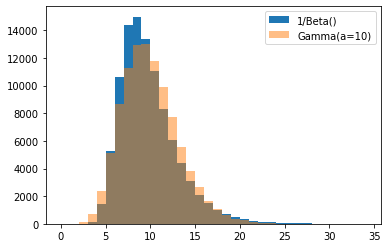

In [296]:
g_prior = gamma(a=10, scale=1)
b_prior = beta(a=12, b=108)
M = 100000
g = g_prior.rvs(M)
b = 1/b_prior.rvs(M) - 1
plt.hist(b, label='1/Beta()', bins=np.arange(0,35,1))
plt.hist(g, label='Gamma(a=10)', bins=np.arange(0,35,1), alpha=0.5)
plt.legend()

np.median(g), np.median(b), np.var(g), np.var(b)


195620 17.828705367714473 0.05311039609312158
17.786545343011962 332.6149728419528

239238 4.2880912228066315 0.1891041507920989
4.28327021626999 22.691345274218975

103151 10.600403261903947 0.08620389976303913
10.577250826458299 122.38632855512179

2744 12.750898440059641 0.07272252095810423
12.616253644314869 170.54770957997943

94066 20.028661863126274 0.047554143316817434
20.083005549295176 428.99857432729254


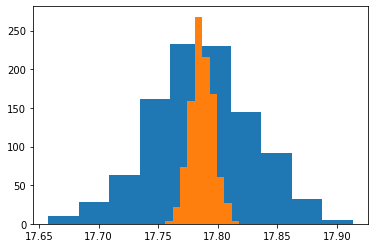

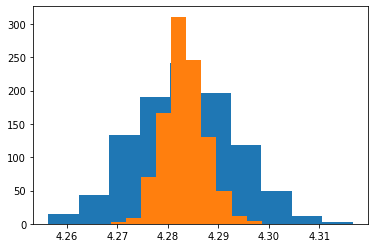

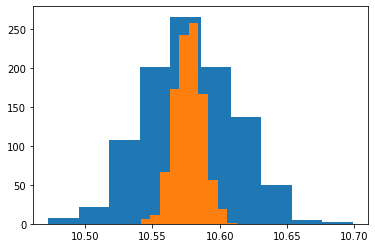

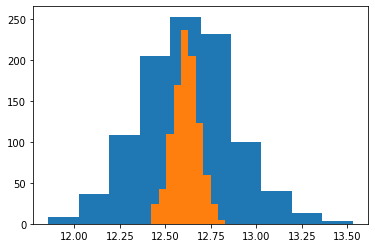

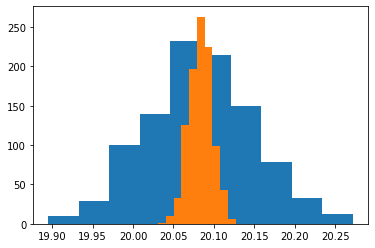

<Figure size 432x288 with 0 Axes>

In [316]:
M = 5
for m in range(M):
    print()
    sample_size = (10**uniform(3,6-3).rvs()).astype(int)
    true_mean = g_prior.rvs()
    p_for_the_geometric = 1/(true_mean+1)
    print(sample_size, true_mean, p_for_the_geometric)
    
    # Generate Geometric data
    g = geom(p=p_for_the_geometric, loc=-1).rvs(sample_size)
    print(np.mean(g), np.var(g))
    
    # Compute the 'correct' posterior, i.e. Beta
    geom_beta_prior = 12, 108 # beta(a=12, b=108)
    geom_beta_posterior = geom_beta_prior[0] + sample_size, geom_beta_prior[1] + np.sum(g)
    
    sample_of_means_from_correct_posterior = 1/beta(*geom_beta_posterior).rvs(1000) - 1
    plt.hist(sample_of_means_from_correct_posterior)
    
    # Let's pretend it's Poisson and see what goes wrong
    
    poisson_gamma_prior = 10, 1  # Gamma(alpha=10, beta=1/1)
    poisson_gamma_posterior = poisson_gamma_prior[0] + np.sum(g), poisson_gamma_prior[1] + sample_size
    wrong_posterior = gamma(a=poisson_gamma_posterior[0], scale=1/poisson_gamma_posterior[1]).rvs(1000)
    plt.hist(wrong_posterior)
    plt.figure()
    
    